# 1.3 Historical Trends

The timeseries plots show a clear seasonality, the function `seasonal_trends` is particularly useful to explore the seasonal variations of each variables but also to compare the variation across different years.

In [1]:
from funciones import*
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep="\t")
#Data=pd.read_csv('https://raw.githubusercontent.com/iceclassic/sandbox/main/Data/Time_series_DATA.txt',index_col=0,skiprows=149)
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Data = Data[Data.index.year < 2022]

:::{card} Exercise 1

Read the documentation for `seasonal_trends` and use the function to plot one of the columns.
:::

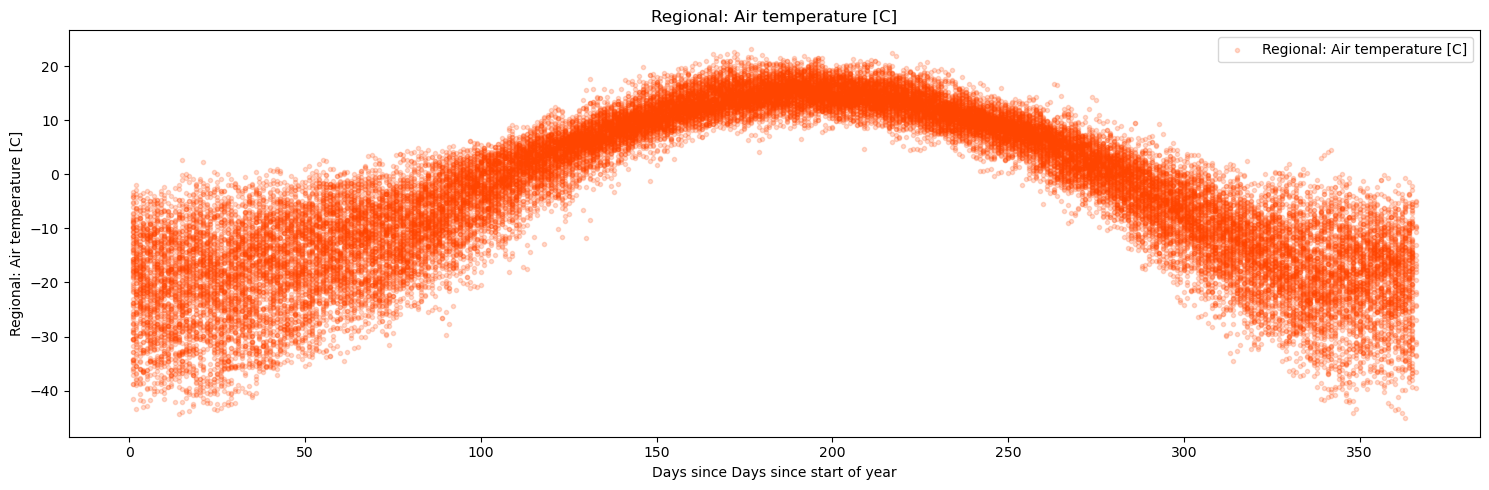

In [2]:
seasonal_trends(Data,columns_to_plot=['Regional: Air temperature [C]'],color='orangered',alpha=0.2)

Plotting the aggregated distribution of the variable across all years is of limited usefulness.

:::{card} Exercise 2
Use the same function as above to plot the baseline (mean and std) over the observations.
:::

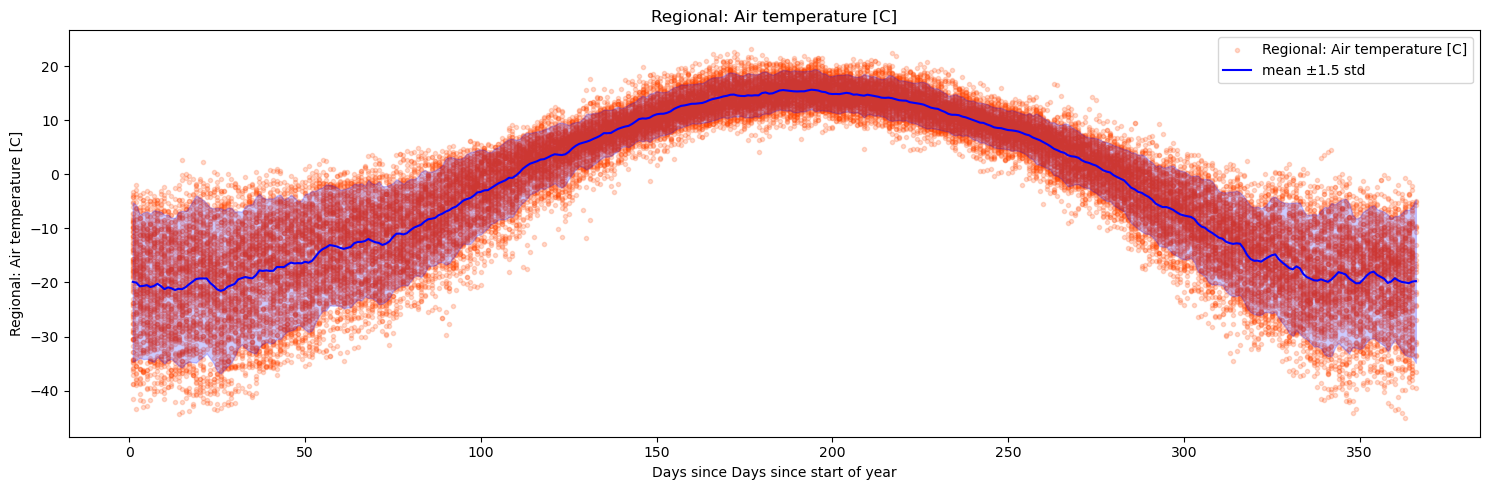

In [3]:
seasonal_trends(Data,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],alpha=0.2,k=1.5,color='orangered')

:::{card} Exercise 3

Use  the arguments  `multiyear` and `Compare_years_to_baseline` to plot the yearly variation of the last years.

:::

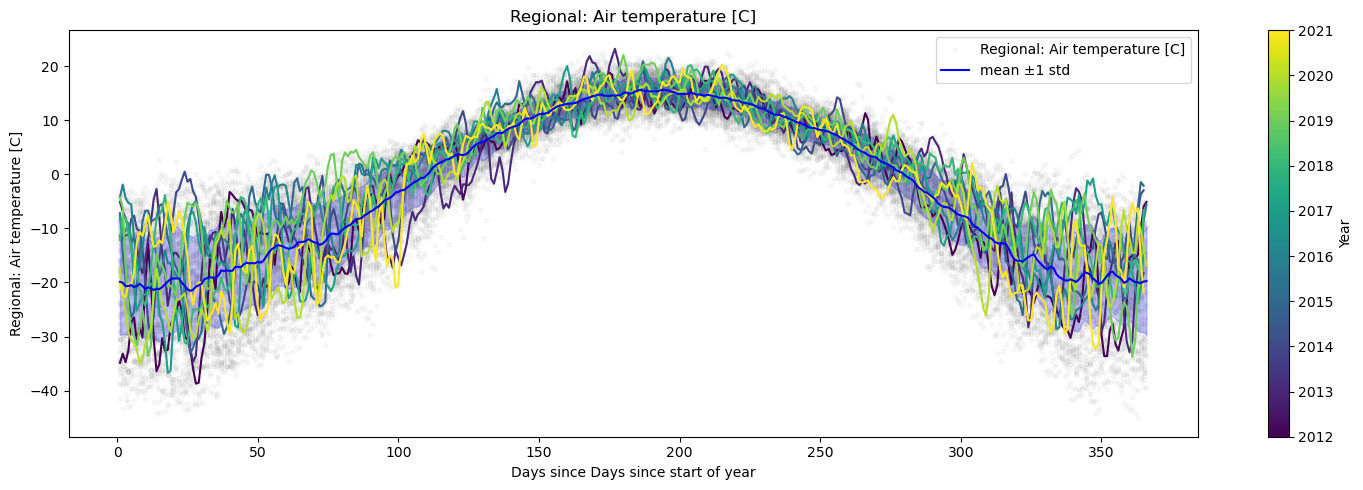

In [4]:
last_decade=np.arange(2012,2022,1)
seasonal_trends(Data,k=1,plot_mean_std=True,multiyear=last_decade,Compare_years_to_baseline=True,columns_to_plot=['Regional: Air temperature [C]'],color='grey',alpha=0.05)

The `seasonal_trends` function primarily extracts the chosen columns for specific days and plots them against another column. By default, this is `xaxis='Days since start of year'`, but any other column can be selected. For instance, setting `xaxis='Days until break-up'` allows us to observe trends leading up to the ice break-up.


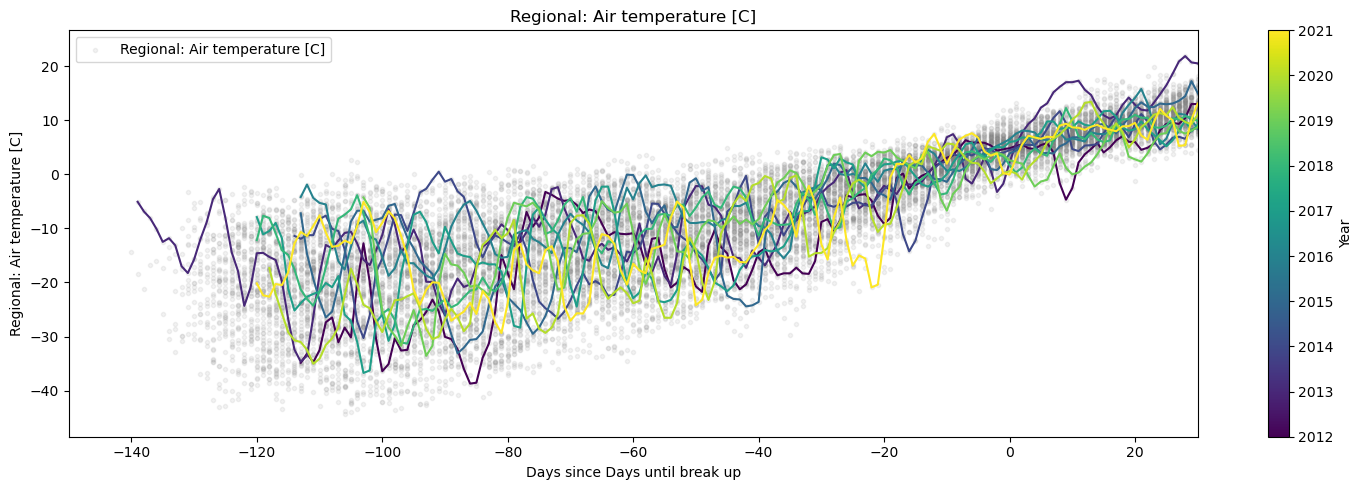

In [5]:
seasonal_trends(Data,multiyear=last_decade,Compare_years_to_baseline=True,
                columns_to_plot=['Regional: Air temperature [C]'],xaxis='Days until break up',color='grey',alpha=0.1,xlim=[-150,30])

As expected, the temperature goes above 0 C in the days leading up the break up, similarly, the discharge starts to increase just before the break-up.

A very simple approach to plot the seasonal variation against others 'x-axis' is to simply create create a dataframe , merge it to the dataframe and use the previous function. Alternatively, the function `days_since_last_date` computes,for each date, the number of date since the last occurrence of that date.

:::{card} Exercise 2
Remake the previous plot, but consider days since the start of winter as the `xaxis` 
:::

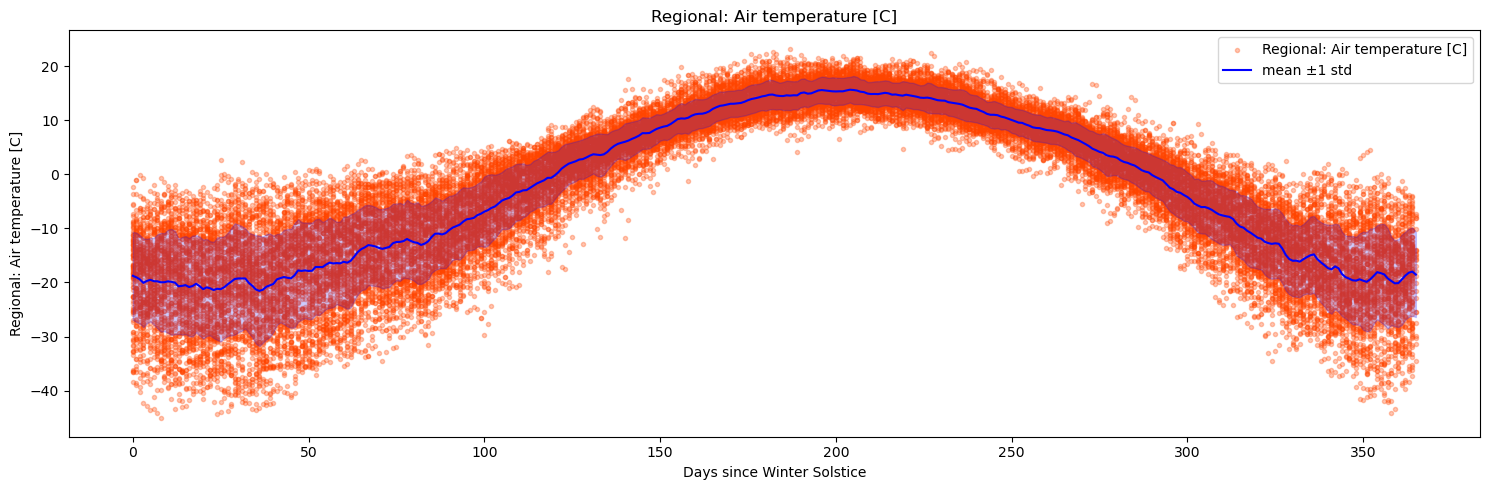

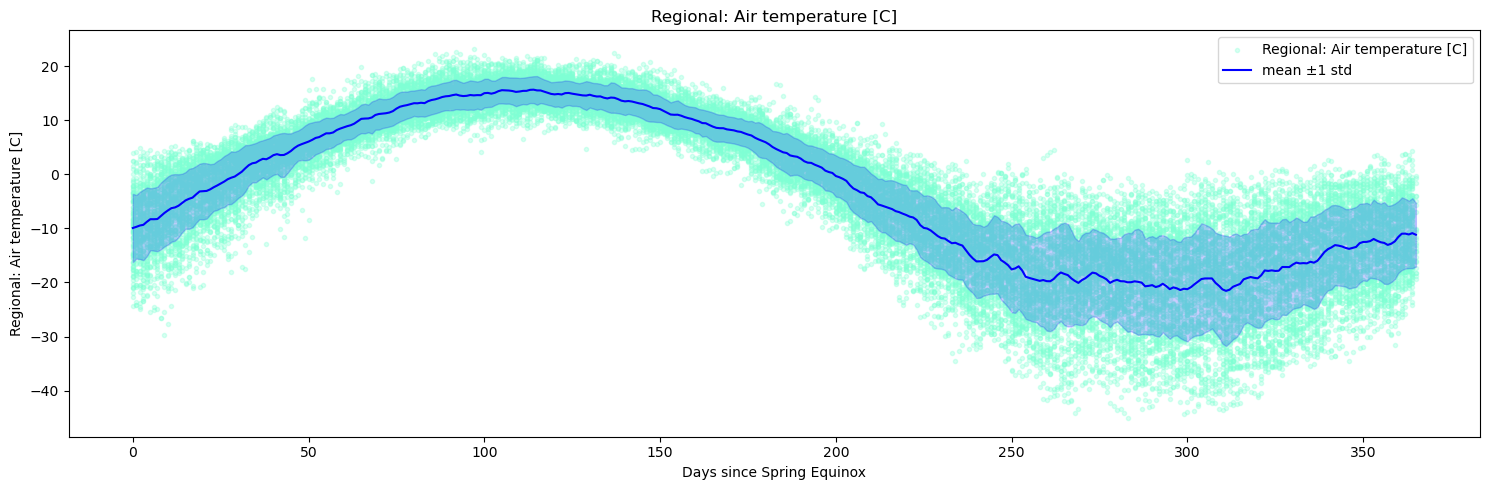

In [6]:
Data=days_since_last_date(Data,date='Winter Solstice')
Data=days_since_last_date(Data,date='Spring Equinox')
seasonal_trends(Data,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Winter Solstice',alpha=0.3,color='orangered')
seasonal_trends(Data,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Spring Equinox',color='aquamarine',alpha=0.3)

We migh want to use an axis that consider the number of daya since a speifi hito, but this could be different year to year.  For exmape, lets try to re-create the plots but considering the umber of days since the temperature went below zero. Even though we saw from previous plot that in evergae this is aorund te frist week of october, it varies year to year. 

Once we have identify this events, we can pass the list t the function and re-create the plot. 

We have few options to extract this list of event, the Naive approach would be to loop trhoug each year and each day of the year and use logic accordingly, a pseucod code that illustrate this apporach is presented 
> see how to add commented code

`for year in Data.index.year.unique():`

    `data_year=Data[Data.index.year=year].copy()`
    
    `for day_of_year in data_year.index:`
    
:::{card}
Re-create the plots but considering, for each winter season, the number of days since the mean dily temperature was under zero for three consecutives days. 
:::

tips about unique, index
explain why rolling mean , and also last ocuuren vs total ocurrances



['1917/01/03', '1917/05/06', '1917/10/05', '1917/10/15', '1918/01/01', '1918/04/17', '1918/04/26', '1918/04/30', '1918/10/14', '1919/01/01', '1919/04/12', '1919/10/01', '1919/10/18', '1919/10/29', '1920/01/01', '1920/05/03', '1920/09/25', '1920/10/02', '1921/01/01', '1921/04/14', '1921/04/23', '1921/09/26', '1921/10/03', '1921/10/09', '1921/10/13', '1922/01/01', '1922/04/08', '1922/05/03', '1922/09/25', '1922/10/19', '1923/01/01', '1923/04/09', '1923/04/25', '1923/09/28', '1923/10/17', '1923/10/31', '1924/01/01', '1924/10/07', '1925/01/01', '1925/04/11', '1925/04/26', '1925/10/23', '1926/01/01', '1926/04/04', '1926/10/08', '1926/10/15', '1926/10/25', '1927/01/01', '1927/04/13', '1927/10/05', '1928/01/01', '1928/10/01', '1928/11/06', '1929/01/01', '1929/10/07', '1929/10/13', '1930/01/01', '1930/04/25', '1930/10/02', '1930/10/11', '1931/01/01', '1931/04/30', '1931/10/03', '1931/10/10', '1932/01/01', '1932/04/20', '1932/09/22', '1932/10/01', '1932/10/14', '1933/01/01', '1933/04/15', '1933

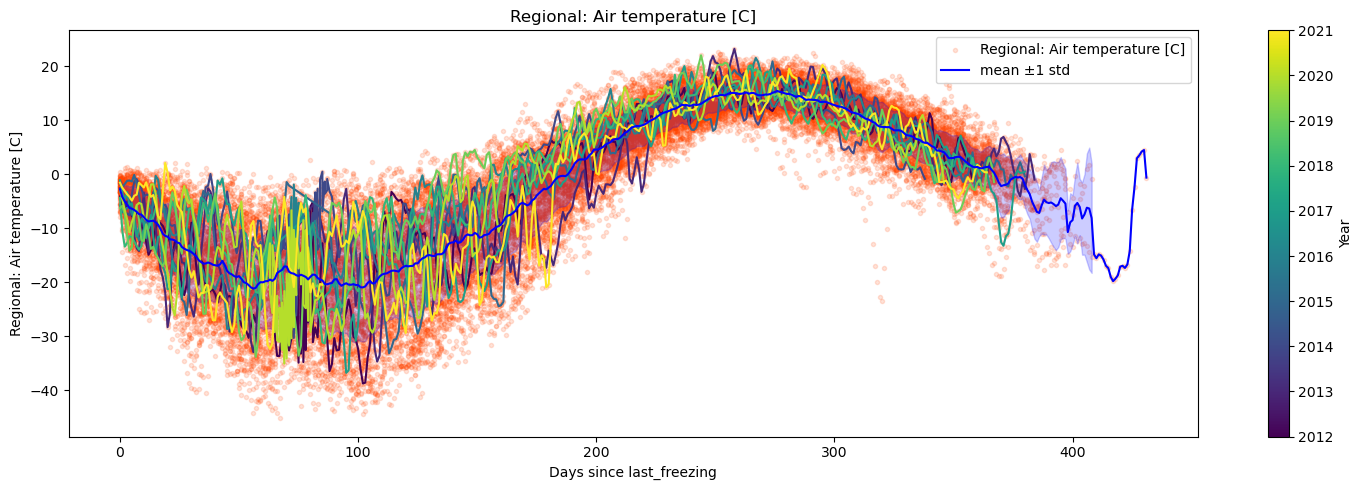

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38542 entries, 1901-02-01 to 2021-12-31
Data columns (total 28 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38351 non-null  float64
 1   Days since start of year                           38351 non-null  float64
 2   Days until break up                                38351 non-null  float64
 3   Nenana: Rainfall [mm]                              28843 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2029 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      21795 non-null  float64
 8   Nenana: Air temperature [C]                        30469 non-null  fl

In [8]:
rolling_avg_below_zero = Data['Regional: Air temperature [C]'].rolling(window=3).mean().lt(0)
Data['starting_to_freeze'] = rolling_avg_below_zero.groupby(Data.index.year).transform(lambda x: x & ~x.shift(1, fill_value=False))
# extrating the dates to check

filtered_data = Data[Data['starting_to_freeze']]
dates_of_occurrences = filtered_data.index.strftime('%Y/%m/%d').tolist()
print(dates_of_occurrences)
# given the logic used in transfomr, we could have mulitple days of beggining of freezng per year, for exmaple an early cold wave that causes the mean to be  below zero, then
# we assuem that this cold wave are to short to produce any ice, or that the ice formed melts after the cold have has pass, then we care about the last starting to freeze as it 
# correspond to the freezinf period that continues throug the winter 
dates_df = pd.DataFrame(pd.to_datetime(Data[Data['starting_to_freeze']].index.strftime('%Y/%m/%d')), columns=['date'])
dates_df['year'] = dates_df['date'].dt.year
latest_dates_formatted = dates_df.groupby('year')['date'].max().dt.strftime('%Y/%m/%d').tolist()

print(latest_dates_formatted)


Data=days_since_last_date(Data,date=latest_dates_formatted,name='last_freezing')

seasonal_trends(Data,k=1,plot_mean_std=True,multiyear=last_decade,Compare_years_to_baseline=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='last_freezing',color='orangered',alpha=0.15)
Data.info()




filtered_data = Data[Data['first_below_zero']]
dates_of_occurrences = filtered_data.index.strftime('%Y/%m/%d').tolist()
dates_of_occurrences = pd.to_datetime(dates_of_occurrences)
dates_df = pd.DataFrame(dates_of_occurrences, columns=['date'])
dates_df['year'] = dates_df['date'].dt.year
latest_dates = dates_df.groupby('year')['date'].max()
latest_dates_formatted = latest_dates.dt.strftime('%Y/%m/%d').tolist()